本章介绍如何使用 TensorFlow 快速搭建动态模型。
* 模型的构建： tf.keras.Model 和 tf.keras.layers
* 模型的损失函数： tf.keras.losses
* 模型的优化器： tf.keras.optimizer
* 模型的评估： tf.keras.metrics


In [1]:
# %config ZMQInteractiveShell.ast_node_interactivity='all'

在 TensorFlow 中，推荐使用 Keras（ tf.keras ）构建模型。

Keras 有两个重要的概念： 模型（Model） 和 层（Layer） 。
    * 层将各种计算流程和变量进行了封装（例如基本的全连接层，CNN 的卷积层、池化层等），
    * 模型则将各种层进行组织和连接，并封装成一个整体，描述了如何将输入数据通过各种层以及运算而得到输出。
      在需要模型调用的时候，使用 y_pred = model(X) 的形式即可。
Keras 在 tf.keras.layers 下内置了深度学习中大量常用的的预定义层，同时也允许我们自定义层。

Keras 模型以类的形式呈现，我们可以通过继承 tf.keras.Model 类来定义自己的模型。
在继承类中，我们需要重写 __init__() （构造函数，初始化）和 call(input) （模型调用）两个方法，同时也可以根据需要增加自定义的方法。
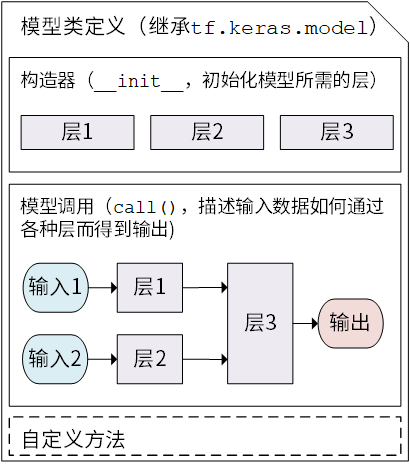

In [2]:
import tensorflow as tf

In [3]:
# 自定义模型 --继承自tf.Keras.Model
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()     # Python 2 下使用 super(MyModel, self).__init__()
        # 此处添加初始化代码（包含 call 方法中会用到的层），例如
        # layer1 = tf.keras.layers.BuiltInLayer(...)
        # layer2 = MyCustomLayer(...)

    def call(self, input):
        # 此处添加模型调用的代码（处理输入并返回输出），例如
        # x = layer1(input)
        # output = layer2(x)
        return output

    # 自定义的方法
    # pass
    

In [4]:
# 例程

In [5]:
import tensorflow as tf

X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y = tf.constant([[10.0], [20.0]])

class Linear(tf.keras.Model):
    def __init__(self):
        super().__init__() # 需要调用父类的__init__()函数
        self.dense = tf.keras.layers.Dense(
            units=1,
            activation=None,
            kernel_initializer=tf.zeros_initializer(),
            bias_initializer=tf.zeros_initializer()
        )

    def call(self, input):
        output = self.dense(input)
        return output


# 以下代码结构与前节类似
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
for i in range(100):
    with tf.GradientTape() as tape:
        y_pred = model(X)      # 调用模型 y_pred = model(X) 而不是显式写出 y_pred = X*w + b
        loss = tf.reduce_mean(tf.square(y_pred - y))
    grads = tape.gradient(loss, model.variables)    # 使用 model.variables 这一属性直接获得模型中的所有变量
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
print(model.variables)

[<tf.Variable 'linear/dense/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.40784496],
       [1.191065  ],
       [1.9742855 ]], dtype=float32)>, <tf.Variable 'linear/dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.78322077], dtype=float32)>]


## 基础示例：多层感知机（MLP）

多层感知机 （Multilayer Perceptron, MLP）,我们依次进行以下步骤：
* 使用 tf.keras.datasets 获得数据集并预处理
* 使用 tf.keras.Model 和 tf.keras.layers 构建模型
* 构建模型训练流程，使用 tf.keras.losses 计算损失函数，并使用 tf.keras.optimizer 优化模型
* 构建模型评估流程，使用 tf.keras.metrics 计算评估指标

我们使用多层感知机完成 MNIST 手写体数字图片数据集 [LeCun1998] 的分类任务。
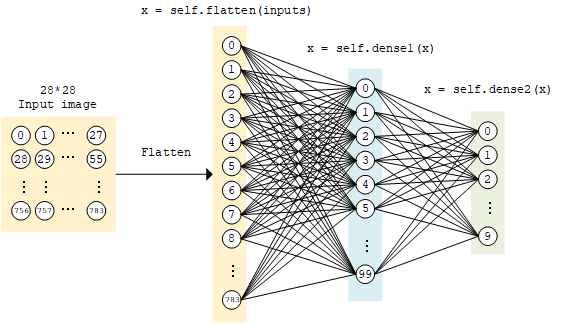

In [9]:
# 数据获取及预处理： tf.keras.datasets
import numpy as np
class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, np.shape(self.train_data)[0], batch_size)
        return self.train_data[index, :], self.train_label[index]
    
# 说明: 在 TensorFlow 中，图像数据集的一种典型表示是 [图像数目，长，宽，色彩通道数] 的四维张量

In [7]:
# 模型的构建： tf.keras.Model 和 tf.keras.layers
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    # Flatten层将除第一维（batch_size）以外的维度展平
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

In [10]:
# 模型的训练： tf.keras.losses 和 tf.keras.optimizer
num_epochs = 5
batch_size = 50
learning_rate = 0.001

data_loader = MNISTLoader()
model = MLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

batch 0: loss 2.321838
batch 1: loss 2.317132
batch 2: loss 2.302468
batch 3: loss 2.138137
batch 4: loss 1.942292
batch 5: loss 1.964702
batch 6: loss 1.871838
batch 7: loss 1.809946
batch 8: loss 1.803239
batch 9: loss 1.723927
batch 10: loss 1.537167
batch 11: loss 1.741627
batch 12: loss 1.598509
batch 13: loss 1.412047
batch 14: loss 1.426788
batch 15: loss 1.368413
batch 16: loss 1.412998
batch 17: loss 1.353366
batch 18: loss 1.264559
batch 19: loss 1.358348
batch 20: loss 1.133303
batch 21: loss 1.095564
batch 22: loss 0.981522
batch 23: loss 1.020669
batch 24: loss 1.105326
batch 25: loss 0.984846
batch 26: loss 0.926984
batch 27: loss 0.855124
batch 28: loss 0.895487
batch 29: loss 0.796914
batch 30: loss 0.976886
batch 31: loss 0.970143
batch 32: loss 0.726915
batch 33: loss 0.865496
batch 34: loss 0.793241
batch 35: loss 0.729056
batch 36: loss 0.872369
batch 37: loss 0.553235
batch 38: loss 0.792811
batch 39: loss 0.729745
batch 40: loss 0.798370
batch 41: loss 0.682941
ba

batch 346: loss 0.202947
batch 347: loss 0.395046
batch 348: loss 0.167395
batch 349: loss 0.392414
batch 350: loss 0.304255
batch 351: loss 0.421702
batch 352: loss 0.329314
batch 353: loss 0.289489
batch 354: loss 0.206478
batch 355: loss 0.236778
batch 356: loss 0.250098
batch 357: loss 0.141982
batch 358: loss 0.172978
batch 359: loss 0.389634
batch 360: loss 0.273783
batch 361: loss 0.382230
batch 362: loss 0.141226
batch 363: loss 0.171312
batch 364: loss 0.164671
batch 365: loss 0.168262
batch 366: loss 0.467107
batch 367: loss 0.343814
batch 368: loss 0.419963
batch 369: loss 0.478039
batch 370: loss 0.370024
batch 371: loss 0.173306
batch 372: loss 0.311510
batch 373: loss 0.512840
batch 374: loss 0.266908
batch 375: loss 0.391524
batch 376: loss 0.327756
batch 377: loss 0.098863
batch 378: loss 0.423569
batch 379: loss 0.188039
batch 380: loss 0.386535
batch 381: loss 0.311706
batch 382: loss 0.183312
batch 383: loss 0.213470
batch 384: loss 0.263120
batch 385: loss 0.241777


batch 704: loss 0.219704
batch 705: loss 0.376828
batch 706: loss 0.297488
batch 707: loss 0.210692
batch 708: loss 0.196620
batch 709: loss 0.523591
batch 710: loss 0.175062
batch 711: loss 0.237849
batch 712: loss 0.225359
batch 713: loss 0.113336
batch 714: loss 0.356069
batch 715: loss 0.182666
batch 716: loss 0.206462
batch 717: loss 0.120127
batch 718: loss 0.180937
batch 719: loss 0.188092
batch 720: loss 0.241141
batch 721: loss 0.111577
batch 722: loss 0.159880
batch 723: loss 0.182532
batch 724: loss 0.188284
batch 725: loss 0.184541
batch 726: loss 0.225361
batch 727: loss 0.273203
batch 728: loss 0.226563
batch 729: loss 0.095714
batch 730: loss 0.100618
batch 731: loss 0.112471
batch 732: loss 0.201637
batch 733: loss 0.351459
batch 734: loss 0.084344
batch 735: loss 0.239979
batch 736: loss 0.108238
batch 737: loss 0.308598
batch 738: loss 0.141875
batch 739: loss 0.353861
batch 740: loss 0.117266
batch 741: loss 0.155198
batch 742: loss 0.115629
batch 743: loss 0.199757


batch 1057: loss 0.163612
batch 1058: loss 0.246454
batch 1059: loss 0.285359
batch 1060: loss 0.074363
batch 1061: loss 0.240996
batch 1062: loss 0.091983
batch 1063: loss 0.354423
batch 1064: loss 0.158345
batch 1065: loss 0.065629
batch 1066: loss 0.156672
batch 1067: loss 0.132835
batch 1068: loss 0.186312
batch 1069: loss 0.123827
batch 1070: loss 0.206093
batch 1071: loss 0.124793
batch 1072: loss 0.302675
batch 1073: loss 0.099144
batch 1074: loss 0.172453
batch 1075: loss 0.205823
batch 1076: loss 0.139698
batch 1077: loss 0.158342
batch 1078: loss 0.107570
batch 1079: loss 0.198831
batch 1080: loss 0.191798
batch 1081: loss 0.217829
batch 1082: loss 0.145827
batch 1083: loss 0.088581
batch 1084: loss 0.126596
batch 1085: loss 0.340003
batch 1086: loss 0.077703
batch 1087: loss 0.273472
batch 1088: loss 0.187375
batch 1089: loss 0.204928
batch 1090: loss 0.133159
batch 1091: loss 0.342950
batch 1092: loss 0.131678
batch 1093: loss 0.191838
batch 1094: loss 0.113074
batch 1095: 

batch 1382: loss 0.241489
batch 1383: loss 0.102553
batch 1384: loss 0.107114
batch 1385: loss 0.198013
batch 1386: loss 0.088761
batch 1387: loss 0.111331
batch 1388: loss 0.187919
batch 1389: loss 0.175416
batch 1390: loss 0.267706
batch 1391: loss 0.042734
batch 1392: loss 0.062595
batch 1393: loss 0.365851
batch 1394: loss 0.255451
batch 1395: loss 0.051231
batch 1396: loss 0.138629
batch 1397: loss 0.138165
batch 1398: loss 0.152538
batch 1399: loss 0.040219
batch 1400: loss 0.135218
batch 1401: loss 0.121556
batch 1402: loss 0.027297
batch 1403: loss 0.140629
batch 1404: loss 0.054885
batch 1405: loss 0.332573
batch 1406: loss 0.249773
batch 1407: loss 0.208758
batch 1408: loss 0.080873
batch 1409: loss 0.074619
batch 1410: loss 0.070069
batch 1411: loss 0.137692
batch 1412: loss 0.037637
batch 1413: loss 0.335288
batch 1414: loss 0.248896
batch 1415: loss 0.051555
batch 1416: loss 0.061958
batch 1417: loss 0.173495
batch 1418: loss 0.049206
batch 1419: loss 0.114611
batch 1420: 

batch 1706: loss 0.227500
batch 1707: loss 0.397186
batch 1708: loss 0.086055
batch 1709: loss 0.121333
batch 1710: loss 0.207770
batch 1711: loss 0.126596
batch 1712: loss 0.066237
batch 1713: loss 0.082379
batch 1714: loss 0.112362
batch 1715: loss 0.075059
batch 1716: loss 0.118148
batch 1717: loss 0.180433
batch 1718: loss 0.041741
batch 1719: loss 0.158764
batch 1720: loss 0.102396
batch 1721: loss 0.233991
batch 1722: loss 0.365880
batch 1723: loss 0.045045
batch 1724: loss 0.096998
batch 1725: loss 0.207865
batch 1726: loss 0.357325
batch 1727: loss 0.123162
batch 1728: loss 0.183754
batch 1729: loss 0.103858
batch 1730: loss 0.202190
batch 1731: loss 0.057972
batch 1732: loss 0.066548
batch 1733: loss 0.171906
batch 1734: loss 0.154911
batch 1735: loss 0.181636
batch 1736: loss 0.040552
batch 1737: loss 0.128072
batch 1738: loss 0.273622
batch 1739: loss 0.110973
batch 1740: loss 0.101383
batch 1741: loss 0.089718
batch 1742: loss 0.296457
batch 1743: loss 0.111922
batch 1744: 

batch 2022: loss 0.117794
batch 2023: loss 0.128443
batch 2024: loss 0.086134
batch 2025: loss 0.106870
batch 2026: loss 0.086830
batch 2027: loss 0.053156
batch 2028: loss 0.049010
batch 2029: loss 0.308372
batch 2030: loss 0.030929
batch 2031: loss 0.157594
batch 2032: loss 0.075348
batch 2033: loss 0.094306
batch 2034: loss 0.113171
batch 2035: loss 0.156190
batch 2036: loss 0.275380
batch 2037: loss 0.087636
batch 2038: loss 0.105093
batch 2039: loss 0.205194
batch 2040: loss 0.052511
batch 2041: loss 0.112059
batch 2042: loss 0.200872
batch 2043: loss 0.127284
batch 2044: loss 0.133712
batch 2045: loss 0.250113
batch 2046: loss 0.152955
batch 2047: loss 0.154225
batch 2048: loss 0.058344
batch 2049: loss 0.118903
batch 2050: loss 0.068415
batch 2051: loss 0.152449
batch 2052: loss 0.039130
batch 2053: loss 0.023550
batch 2054: loss 0.030307
batch 2055: loss 0.078474
batch 2056: loss 0.298515
batch 2057: loss 0.179963
batch 2058: loss 0.097415
batch 2059: loss 0.060704
batch 2060: 

batch 2374: loss 0.233077
batch 2375: loss 0.039783
batch 2376: loss 0.122260
batch 2377: loss 0.042383
batch 2378: loss 0.080305
batch 2379: loss 0.263755
batch 2380: loss 0.354589
batch 2381: loss 0.037400
batch 2382: loss 0.020590
batch 2383: loss 0.132389
batch 2384: loss 0.058480
batch 2385: loss 0.046306
batch 2386: loss 0.164535
batch 2387: loss 0.009487
batch 2388: loss 0.162050
batch 2389: loss 0.087261
batch 2390: loss 0.061216
batch 2391: loss 0.112182
batch 2392: loss 0.063780
batch 2393: loss 0.151568
batch 2394: loss 0.088629
batch 2395: loss 0.053068
batch 2396: loss 0.122517
batch 2397: loss 0.214103
batch 2398: loss 0.055109
batch 2399: loss 0.105433
batch 2400: loss 0.008805
batch 2401: loss 0.063871
batch 2402: loss 0.144325
batch 2403: loss 0.099841
batch 2404: loss 0.108952
batch 2405: loss 0.111789
batch 2406: loss 0.123463
batch 2407: loss 0.116611
batch 2408: loss 0.115446
batch 2409: loss 0.078879
batch 2410: loss 0.031985
batch 2411: loss 0.269858
batch 2412: 

batch 2724: loss 0.157119
batch 2725: loss 0.059135
batch 2726: loss 0.099263
batch 2727: loss 0.102322
batch 2728: loss 0.217947
batch 2729: loss 0.251997
batch 2730: loss 0.082469
batch 2731: loss 0.112224
batch 2732: loss 0.038987
batch 2733: loss 0.145877
batch 2734: loss 0.080019
batch 2735: loss 0.161690
batch 2736: loss 0.098382
batch 2737: loss 0.036993
batch 2738: loss 0.160340
batch 2739: loss 0.170349
batch 2740: loss 0.028790
batch 2741: loss 0.073426
batch 2742: loss 0.039190
batch 2743: loss 0.047294
batch 2744: loss 0.058404
batch 2745: loss 0.086863
batch 2746: loss 0.126124
batch 2747: loss 0.094018
batch 2748: loss 0.152307
batch 2749: loss 0.068992
batch 2750: loss 0.137035
batch 2751: loss 0.202505
batch 2752: loss 0.082400
batch 2753: loss 0.266192
batch 2754: loss 0.031143
batch 2755: loss 0.056795
batch 2756: loss 0.064079
batch 2757: loss 0.101732
batch 2758: loss 0.056619
batch 2759: loss 0.073958
batch 2760: loss 0.033154
batch 2761: loss 0.182096
batch 2762: 

batch 3079: loss 0.046084
batch 3080: loss 0.149525
batch 3081: loss 0.040126
batch 3082: loss 0.197836
batch 3083: loss 0.185998
batch 3084: loss 0.100868
batch 3085: loss 0.067873
batch 3086: loss 0.039833
batch 3087: loss 0.138022
batch 3088: loss 0.045290
batch 3089: loss 0.039913
batch 3090: loss 0.050515
batch 3091: loss 0.100895
batch 3092: loss 0.125746
batch 3093: loss 0.159633
batch 3094: loss 0.080799
batch 3095: loss 0.043121
batch 3096: loss 0.031916
batch 3097: loss 0.095245
batch 3098: loss 0.100269
batch 3099: loss 0.114181
batch 3100: loss 0.042569
batch 3101: loss 0.033672
batch 3102: loss 0.103539
batch 3103: loss 0.064297
batch 3104: loss 0.354312
batch 3105: loss 0.076440
batch 3106: loss 0.401121
batch 3107: loss 0.107589
batch 3108: loss 0.091013
batch 3109: loss 0.042552
batch 3110: loss 0.039732
batch 3111: loss 0.075360
batch 3112: loss 0.037003
batch 3113: loss 0.019076
batch 3114: loss 0.023973
batch 3115: loss 0.156278
batch 3116: loss 0.099219
batch 3117: 

batch 3430: loss 0.152111
batch 3431: loss 0.083149
batch 3432: loss 0.045833
batch 3433: loss 0.047582
batch 3434: loss 0.131268
batch 3435: loss 0.095568
batch 3436: loss 0.065385
batch 3437: loss 0.054732
batch 3438: loss 0.038450
batch 3439: loss 0.092356
batch 3440: loss 0.047563
batch 3441: loss 0.056419
batch 3442: loss 0.213100
batch 3443: loss 0.061424
batch 3444: loss 0.056869
batch 3445: loss 0.032462
batch 3446: loss 0.065161
batch 3447: loss 0.096579
batch 3448: loss 0.104169
batch 3449: loss 0.035945
batch 3450: loss 0.059166
batch 3451: loss 0.032422
batch 3452: loss 0.114767
batch 3453: loss 0.071724
batch 3454: loss 0.116149
batch 3455: loss 0.095821
batch 3456: loss 0.154162
batch 3457: loss 0.074787
batch 3458: loss 0.107679
batch 3459: loss 0.063740
batch 3460: loss 0.015856
batch 3461: loss 0.139868
batch 3462: loss 0.027856
batch 3463: loss 0.259806
batch 3464: loss 0.039357
batch 3465: loss 0.035031
batch 3466: loss 0.055765
batch 3467: loss 0.167716
batch 3468: 

batch 3747: loss 0.033926
batch 3748: loss 0.042215
batch 3749: loss 0.020778
batch 3750: loss 0.098185
batch 3751: loss 0.054650
batch 3752: loss 0.037574
batch 3753: loss 0.101156
batch 3754: loss 0.040818
batch 3755: loss 0.105114
batch 3756: loss 0.062635
batch 3757: loss 0.032427
batch 3758: loss 0.107927
batch 3759: loss 0.035828
batch 3760: loss 0.224506
batch 3761: loss 0.145779
batch 3762: loss 0.033682
batch 3763: loss 0.132481
batch 3764: loss 0.051150
batch 3765: loss 0.112753
batch 3766: loss 0.070601
batch 3767: loss 0.096977
batch 3768: loss 0.076690
batch 3769: loss 0.109281
batch 3770: loss 0.035504
batch 3771: loss 0.079431
batch 3772: loss 0.033952
batch 3773: loss 0.141895
batch 3774: loss 0.091047
batch 3775: loss 0.052754
batch 3776: loss 0.018085
batch 3777: loss 0.045678
batch 3778: loss 0.111886
batch 3779: loss 0.151158
batch 3780: loss 0.032132
batch 3781: loss 0.017704
batch 3782: loss 0.028155
batch 3783: loss 0.133281
batch 3784: loss 0.237002
batch 3785: 

batch 4066: loss 0.072318
batch 4067: loss 0.079173
batch 4068: loss 0.161431
batch 4069: loss 0.047567
batch 4070: loss 0.071560
batch 4071: loss 0.082030
batch 4072: loss 0.060218
batch 4073: loss 0.111562
batch 4074: loss 0.138835
batch 4075: loss 0.182167
batch 4076: loss 0.044945
batch 4077: loss 0.035906
batch 4078: loss 0.154559
batch 4079: loss 0.042926
batch 4080: loss 0.018342
batch 4081: loss 0.248300
batch 4082: loss 0.125938
batch 4083: loss 0.024725
batch 4084: loss 0.024757
batch 4085: loss 0.044597
batch 4086: loss 0.089382
batch 4087: loss 0.072070
batch 4088: loss 0.068191
batch 4089: loss 0.092860
batch 4090: loss 0.188902
batch 4091: loss 0.058885
batch 4092: loss 0.027746
batch 4093: loss 0.349007
batch 4094: loss 0.220658
batch 4095: loss 0.055490
batch 4096: loss 0.103994
batch 4097: loss 0.135654
batch 4098: loss 0.286953
batch 4099: loss 0.043645
batch 4100: loss 0.092341
batch 4101: loss 0.086694
batch 4102: loss 0.265151
batch 4103: loss 0.021193
batch 4104: 

batch 4386: loss 0.033535
batch 4387: loss 0.041593
batch 4388: loss 0.018357
batch 4389: loss 0.054044
batch 4390: loss 0.026109
batch 4391: loss 0.131204
batch 4392: loss 0.057235
batch 4393: loss 0.019023
batch 4394: loss 0.042199
batch 4395: loss 0.024223
batch 4396: loss 0.042733
batch 4397: loss 0.062844
batch 4398: loss 0.048919
batch 4399: loss 0.016835
batch 4400: loss 0.157257
batch 4401: loss 0.018603
batch 4402: loss 0.051726
batch 4403: loss 0.017297
batch 4404: loss 0.136047
batch 4405: loss 0.025706
batch 4406: loss 0.021496
batch 4407: loss 0.019317
batch 4408: loss 0.018229
batch 4409: loss 0.044758
batch 4410: loss 0.043974
batch 4411: loss 0.061866
batch 4412: loss 0.012107
batch 4413: loss 0.027069
batch 4414: loss 0.013960
batch 4415: loss 0.015570
batch 4416: loss 0.110804
batch 4417: loss 0.027510
batch 4418: loss 0.084062
batch 4419: loss 0.037022
batch 4420: loss 0.066966
batch 4421: loss 0.052331
batch 4422: loss 0.062576
batch 4423: loss 0.089930
batch 4424: 

batch 4704: loss 0.016452
batch 4705: loss 0.039379
batch 4706: loss 0.036015
batch 4707: loss 0.015569
batch 4708: loss 0.086495
batch 4709: loss 0.028327
batch 4710: loss 0.033686
batch 4711: loss 0.025012
batch 4712: loss 0.053874
batch 4713: loss 0.049756
batch 4714: loss 0.106862
batch 4715: loss 0.019267
batch 4716: loss 0.119503
batch 4717: loss 0.037364
batch 4718: loss 0.030453
batch 4719: loss 0.048527
batch 4720: loss 0.054354
batch 4721: loss 0.066281
batch 4722: loss 0.035613
batch 4723: loss 0.039391
batch 4724: loss 0.071780
batch 4725: loss 0.027608
batch 4726: loss 0.092221
batch 4727: loss 0.083403
batch 4728: loss 0.016232
batch 4729: loss 0.024957
batch 4730: loss 0.078799
batch 4731: loss 0.119225
batch 4732: loss 0.016056
batch 4733: loss 0.090774
batch 4734: loss 0.047615
batch 4735: loss 0.069261
batch 4736: loss 0.055413
batch 4737: loss 0.129042
batch 4738: loss 0.026618
batch 4739: loss 0.089089
batch 4740: loss 0.087648
batch 4741: loss 0.061129
batch 4742: 

batch 5023: loss 0.040386
batch 5024: loss 0.028246
batch 5025: loss 0.167773
batch 5026: loss 0.027846
batch 5027: loss 0.067466
batch 5028: loss 0.060941
batch 5029: loss 0.041989
batch 5030: loss 0.017069
batch 5031: loss 0.026504
batch 5032: loss 0.081296
batch 5033: loss 0.068883
batch 5034: loss 0.014397
batch 5035: loss 0.046149
batch 5036: loss 0.063657
batch 5037: loss 0.149402
batch 5038: loss 0.026736
batch 5039: loss 0.167760
batch 5040: loss 0.018717
batch 5041: loss 0.067595
batch 5042: loss 0.354588
batch 5043: loss 0.096174
batch 5044: loss 0.158590
batch 5045: loss 0.160144
batch 5046: loss 0.032231
batch 5047: loss 0.144461
batch 5048: loss 0.097113
batch 5049: loss 0.044489
batch 5050: loss 0.062277
batch 5051: loss 0.062245
batch 5052: loss 0.047862
batch 5053: loss 0.057472
batch 5054: loss 0.023181
batch 5055: loss 0.032333
batch 5056: loss 0.018113
batch 5057: loss 0.051929
batch 5058: loss 0.074923
batch 5059: loss 0.041514
batch 5060: loss 0.016933
batch 5061: 

batch 5343: loss 0.020475
batch 5344: loss 0.029947
batch 5345: loss 0.024573
batch 5346: loss 0.082909
batch 5347: loss 0.020309
batch 5348: loss 0.085915
batch 5349: loss 0.130336
batch 5350: loss 0.122502
batch 5351: loss 0.021930
batch 5352: loss 0.016130
batch 5353: loss 0.045299
batch 5354: loss 0.021461
batch 5355: loss 0.064643
batch 5356: loss 0.035097
batch 5357: loss 0.011330
batch 5358: loss 0.044608
batch 5359: loss 0.051415
batch 5360: loss 0.015527
batch 5361: loss 0.229548
batch 5362: loss 0.020833
batch 5363: loss 0.009412
batch 5364: loss 0.011548
batch 5365: loss 0.042153
batch 5366: loss 0.176356
batch 5367: loss 0.125607
batch 5368: loss 0.049078
batch 5369: loss 0.048748
batch 5370: loss 0.011850
batch 5371: loss 0.008786
batch 5372: loss 0.030210
batch 5373: loss 0.028436
batch 5374: loss 0.155270
batch 5375: loss 0.024107
batch 5376: loss 0.024740
batch 5377: loss 0.133926
batch 5378: loss 0.044708
batch 5379: loss 0.056163
batch 5380: loss 0.017771
batch 5381: 

batch 5663: loss 0.107275
batch 5664: loss 0.043553
batch 5665: loss 0.011377
batch 5666: loss 0.081665
batch 5667: loss 0.032439
batch 5668: loss 0.043271
batch 5669: loss 0.025525
batch 5670: loss 0.019232
batch 5671: loss 0.166811
batch 5672: loss 0.099545
batch 5673: loss 0.047211
batch 5674: loss 0.039302
batch 5675: loss 0.035291
batch 5676: loss 0.046960
batch 5677: loss 0.045083
batch 5678: loss 0.026738
batch 5679: loss 0.009160
batch 5680: loss 0.105881
batch 5681: loss 0.033988
batch 5682: loss 0.025782
batch 5683: loss 0.042035
batch 5684: loss 0.040205
batch 5685: loss 0.212018
batch 5686: loss 0.022911
batch 5687: loss 0.181165
batch 5688: loss 0.028837
batch 5689: loss 0.015159
batch 5690: loss 0.022973
batch 5691: loss 0.009207
batch 5692: loss 0.027015
batch 5693: loss 0.023703
batch 5694: loss 0.015144
batch 5695: loss 0.013457
batch 5696: loss 0.018970
batch 5697: loss 0.067406
batch 5698: loss 0.063152
batch 5699: loss 0.020832
batch 5700: loss 0.169252
batch 5701: 

batch 5983: loss 0.084756
batch 5984: loss 0.165928
batch 5985: loss 0.019517
batch 5986: loss 0.063002
batch 5987: loss 0.058030
batch 5988: loss 0.005803
batch 5989: loss 0.055822
batch 5990: loss 0.031895
batch 5991: loss 0.022494
batch 5992: loss 0.026434
batch 5993: loss 0.066531
batch 5994: loss 0.036058
batch 5995: loss 0.052478
batch 5996: loss 0.039330
batch 5997: loss 0.110260
batch 5998: loss 0.024810
batch 5999: loss 0.041194


In [13]:
# 模型的评估： tf.keras.metrics
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], \
                                             y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

test accuracy: 0.974200


## 卷积神经网络（Convolutional Neural Network, CNN）

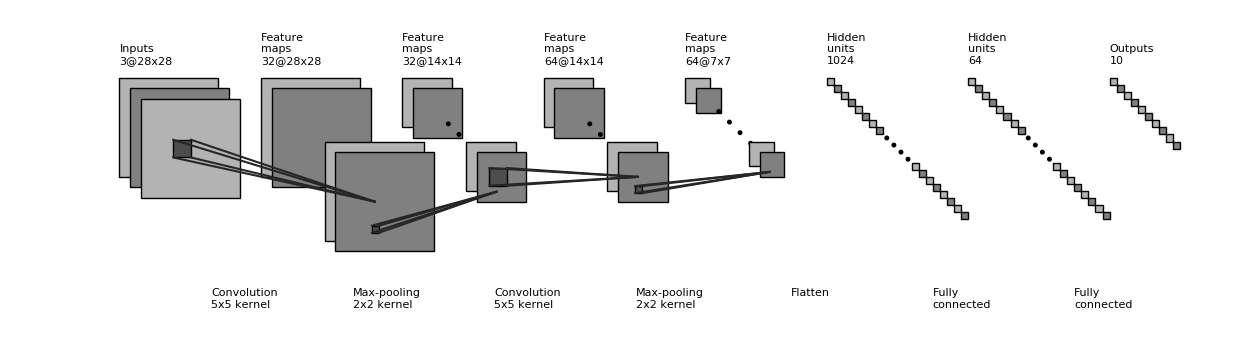

In [16]:
# 使用 Keras 实现卷积神经网络
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32,             # 卷积层神经元（卷积核）数目
            kernel_size=[5, 5],     # 感受野大小
            padding='same',          # padding策略（vaild 或 same）
            activation=tf.nn.relu   # 激活函数
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[5, 5],
            padding='same',
            activation=tf.nn.relu
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        self.dense1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):
        x = self.conv1(inputs)                  # [batch_size, 28, 28, 32]
        x = self.pool1(x)                       # [batch_size, 14, 14, 32]
        x = self.conv2(x)                       # [batch_size, 14, 14, 64]
        x = self.pool2(x)                       # [batch_size, 7, 7, 64]
        x = self.flatten(x)                     # [batch_size, 7 * 7 * 64]
        x = self.dense1(x)                      # [batch_size, 1024]
        x = self.dense2(x)                      # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

In [17]:
# 模型的训练： tf.keras.losses 和 tf.keras.optimizer
num_epochs = 5
batch_size = 50
learning_rate = 0.001

data_loader = MNISTLoader()
model = CNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

num_batches = int(data_loader.num_train_data // batch_size * num_epochs)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    
# 模型的评估： tf.keras.metrics
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
num_batches = int(data_loader.num_test_data // batch_size)
for batch_index in range(num_batches):
    start_index, end_index = batch_index * batch_size, (batch_index + 1) * batch_size
    y_pred = model.predict(data_loader.test_data[start_index: end_index])
    sparse_categorical_accuracy.update_state(y_true=data_loader.test_label[start_index: end_index], \
                                             y_pred=y_pred)
print("test accuracy: %f" % sparse_categorical_accuracy.result())

batch 0: loss 2.312464
batch 1: loss 2.329756
batch 2: loss 2.177441
batch 3: loss 2.122817
batch 4: loss 2.001362
batch 5: loss 1.829823
batch 6: loss 1.503841
batch 7: loss 1.314363
batch 8: loss 1.201313
batch 9: loss 1.021959
batch 10: loss 0.916878
batch 11: loss 0.769910
batch 12: loss 0.760333
batch 13: loss 0.871912
batch 14: loss 0.891022
batch 15: loss 0.909671
batch 16: loss 0.907645
batch 17: loss 1.072899
batch 18: loss 0.807351
batch 19: loss 0.537479
batch 20: loss 0.318298
batch 21: loss 0.570443
batch 22: loss 1.238964
batch 23: loss 0.851946
batch 24: loss 0.403008
batch 25: loss 0.483681
batch 26: loss 0.345987
batch 27: loss 0.614228
batch 28: loss 0.513193
batch 29: loss 0.367725
batch 30: loss 0.541192
batch 31: loss 0.504272
batch 32: loss 0.275665
batch 33: loss 0.252363
batch 34: loss 0.537615
batch 35: loss 0.179484
batch 36: loss 0.261610
batch 37: loss 0.254781
batch 38: loss 0.453947
batch 39: loss 0.583362
batch 40: loss 0.313628
batch 41: loss 0.305826
ba

batch 335: loss 0.059625
batch 336: loss 0.115226
batch 337: loss 0.047273
batch 338: loss 0.058176
batch 339: loss 0.047285
batch 340: loss 0.120297
batch 341: loss 0.354592
batch 342: loss 0.094063
batch 343: loss 0.154931
batch 344: loss 0.059787
batch 345: loss 0.075718
batch 346: loss 0.072403
batch 347: loss 0.132256
batch 348: loss 0.037584
batch 349: loss 0.142962
batch 350: loss 0.030349
batch 351: loss 0.023818
batch 352: loss 0.056111
batch 353: loss 0.097996
batch 354: loss 0.092847
batch 355: loss 0.098202
batch 356: loss 0.071746
batch 357: loss 0.068885
batch 358: loss 0.163877
batch 359: loss 0.110451
batch 360: loss 0.338767
batch 361: loss 0.004122
batch 362: loss 0.077842
batch 363: loss 0.186512
batch 364: loss 0.012747
batch 365: loss 0.071224
batch 366: loss 0.048739
batch 367: loss 0.059634
batch 368: loss 0.003939
batch 369: loss 0.032902
batch 370: loss 0.135912
batch 371: loss 0.062897
batch 372: loss 0.006911
batch 373: loss 0.029397
batch 374: loss 0.104794


batch 665: loss 0.016068
batch 666: loss 0.111534
batch 667: loss 0.045269
batch 668: loss 0.026257
batch 669: loss 0.014909
batch 670: loss 0.010268
batch 671: loss 0.100900
batch 672: loss 0.069533
batch 673: loss 0.004748
batch 674: loss 0.016553
batch 675: loss 0.005406
batch 676: loss 0.066530
batch 677: loss 0.008209
batch 678: loss 0.050730
batch 679: loss 0.019084
batch 680: loss 0.077165
batch 681: loss 0.032855
batch 682: loss 0.046770
batch 683: loss 0.010008
batch 684: loss 0.085075
batch 685: loss 0.090533
batch 686: loss 0.008754
batch 687: loss 0.092640
batch 688: loss 0.045083
batch 689: loss 0.027713
batch 690: loss 0.079906
batch 691: loss 0.012031
batch 692: loss 0.007628
batch 693: loss 0.102730
batch 694: loss 0.052280
batch 695: loss 0.034502
batch 696: loss 0.013114
batch 697: loss 0.010174
batch 698: loss 0.022968
batch 699: loss 0.103806
batch 700: loss 0.037972
batch 701: loss 0.071909
batch 702: loss 0.172769
batch 703: loss 0.006278
batch 704: loss 0.002373


batch 994: loss 0.013061
batch 995: loss 0.009707
batch 996: loss 0.040164
batch 997: loss 0.006071
batch 998: loss 0.087812
batch 999: loss 0.007345
batch 1000: loss 0.199775
batch 1001: loss 0.115819
batch 1002: loss 0.020333
batch 1003: loss 0.001440
batch 1004: loss 0.191598
batch 1005: loss 0.032140
batch 1006: loss 0.025987
batch 1007: loss 0.016655
batch 1008: loss 0.011155
batch 1009: loss 0.014828
batch 1010: loss 0.059858
batch 1011: loss 0.008111
batch 1012: loss 0.018118
batch 1013: loss 0.023856
batch 1014: loss 0.014360
batch 1015: loss 0.018563
batch 1016: loss 0.069746
batch 1017: loss 0.026428
batch 1018: loss 0.019367
batch 1019: loss 0.027403
batch 1020: loss 0.040532
batch 1021: loss 0.039229
batch 1022: loss 0.011908
batch 1023: loss 0.004617
batch 1024: loss 0.017959
batch 1025: loss 0.012357
batch 1026: loss 0.003537
batch 1027: loss 0.001061
batch 1028: loss 0.013173
batch 1029: loss 0.011944
batch 1030: loss 0.050148
batch 1031: loss 0.002621
batch 1032: loss 0

batch 1312: loss 0.068420
batch 1313: loss 0.007657
batch 1314: loss 0.059562
batch 1315: loss 0.027955
batch 1316: loss 0.026407
batch 1317: loss 0.065875
batch 1318: loss 0.030831
batch 1319: loss 0.007052
batch 1320: loss 0.006961
batch 1321: loss 0.018983
batch 1322: loss 0.009571
batch 1323: loss 0.045884
batch 1324: loss 0.005074
batch 1325: loss 0.007937
batch 1326: loss 0.082793
batch 1327: loss 0.003545
batch 1328: loss 0.013114
batch 1329: loss 0.023963
batch 1330: loss 0.007453
batch 1331: loss 0.005703
batch 1332: loss 0.012016
batch 1333: loss 0.049287
batch 1334: loss 0.030489
batch 1335: loss 0.001291
batch 1336: loss 0.022772
batch 1337: loss 0.001875
batch 1338: loss 0.081855
batch 1339: loss 0.004414
batch 1340: loss 0.148992
batch 1341: loss 0.134661
batch 1342: loss 0.004767
batch 1343: loss 0.048890
batch 1344: loss 0.011672
batch 1345: loss 0.002759
batch 1346: loss 0.001950
batch 1347: loss 0.001612
batch 1348: loss 0.001944
batch 1349: loss 0.028030
batch 1350: 

batch 1630: loss 0.002297
batch 1631: loss 0.015149
batch 1632: loss 0.021601
batch 1633: loss 0.024672
batch 1634: loss 0.002704
batch 1635: loss 0.023465
batch 1636: loss 0.004889
batch 1637: loss 0.003978
batch 1638: loss 0.020835
batch 1639: loss 0.032236
batch 1640: loss 0.010711
batch 1641: loss 0.024625
batch 1642: loss 0.001702
batch 1643: loss 0.002416
batch 1644: loss 0.000118
batch 1645: loss 0.099622
batch 1646: loss 0.002755
batch 1647: loss 0.022804
batch 1648: loss 0.104650
batch 1649: loss 0.001014
batch 1650: loss 0.001367
batch 1651: loss 0.059303
batch 1652: loss 0.000681
batch 1653: loss 0.001688
batch 1654: loss 0.000702
batch 1655: loss 0.057865
batch 1656: loss 0.087071
batch 1657: loss 0.008299
batch 1658: loss 0.007469
batch 1659: loss 0.005743
batch 1660: loss 0.048359
batch 1661: loss 0.019990
batch 1662: loss 0.020848
batch 1663: loss 0.001359
batch 1664: loss 0.028725
batch 1665: loss 0.066096
batch 1666: loss 0.039694
batch 1667: loss 0.001219
batch 1668: 

batch 1948: loss 0.001233
batch 1949: loss 0.035585
batch 1950: loss 0.003302
batch 1951: loss 0.127702
batch 1952: loss 0.155732
batch 1953: loss 0.270219
batch 1954: loss 0.094165
batch 1955: loss 0.086477
batch 1956: loss 0.002885
batch 1957: loss 0.043891
batch 1958: loss 0.010019
batch 1959: loss 0.053892
batch 1960: loss 0.004601
batch 1961: loss 0.005370
batch 1962: loss 0.101795
batch 1963: loss 0.065020
batch 1964: loss 0.024482
batch 1965: loss 0.002324
batch 1966: loss 0.029453
batch 1967: loss 0.015177
batch 1968: loss 0.006882
batch 1969: loss 0.003070
batch 1970: loss 0.004828
batch 1971: loss 0.013472
batch 1972: loss 0.003457
batch 1973: loss 0.013117
batch 1974: loss 0.002749
batch 1975: loss 0.009164
batch 1976: loss 0.039424
batch 1977: loss 0.006595
batch 1978: loss 0.005793
batch 1979: loss 0.013568
batch 1980: loss 0.037140
batch 1981: loss 0.086308
batch 1982: loss 0.013580
batch 1983: loss 0.003765
batch 1984: loss 0.014944
batch 1985: loss 0.018561
batch 1986: 

batch 2267: loss 0.046880
batch 2268: loss 0.086787
batch 2269: loss 0.005576
batch 2270: loss 0.002041
batch 2271: loss 0.027361
batch 2272: loss 0.004178
batch 2273: loss 0.146922
batch 2274: loss 0.012655
batch 2275: loss 0.045507
batch 2276: loss 0.000897
batch 2277: loss 0.038816
batch 2278: loss 0.025212
batch 2279: loss 0.021236
batch 2280: loss 0.005602
batch 2281: loss 0.025637
batch 2282: loss 0.045537
batch 2283: loss 0.026128
batch 2284: loss 0.004439
batch 2285: loss 0.100486
batch 2286: loss 0.000923
batch 2287: loss 0.014540
batch 2288: loss 0.141020
batch 2289: loss 0.008549
batch 2290: loss 0.155941
batch 2291: loss 0.008032
batch 2292: loss 0.014831
batch 2293: loss 0.048244
batch 2294: loss 0.026541
batch 2295: loss 0.011100
batch 2296: loss 0.022831
batch 2297: loss 0.002607
batch 2298: loss 0.264554
batch 2299: loss 0.010290
batch 2300: loss 0.050682
batch 2301: loss 0.003037
batch 2302: loss 0.077117
batch 2303: loss 0.015180
batch 2304: loss 0.032336
batch 2305: 

batch 2899: loss 0.058382
batch 2900: loss 0.024519
batch 2901: loss 0.006765
batch 2902: loss 0.003727
batch 2903: loss 0.047364
batch 2904: loss 0.027427
batch 2905: loss 0.038493
batch 2906: loss 0.000931
batch 2907: loss 0.068244
batch 2908: loss 0.005131
batch 2909: loss 0.000385
batch 2910: loss 0.006718
batch 2911: loss 0.005672
batch 2912: loss 0.000604
batch 2913: loss 0.015977
batch 2914: loss 0.032424
batch 2915: loss 0.007008
batch 2916: loss 0.045238
batch 2917: loss 0.052986
batch 2918: loss 0.041744
batch 2919: loss 0.011170
batch 2920: loss 0.000814
batch 2921: loss 0.001855
batch 2922: loss 0.018380
batch 2923: loss 0.002367
batch 2924: loss 0.001643
batch 2925: loss 0.000768
batch 2926: loss 0.004052
batch 2927: loss 0.000898
batch 2928: loss 0.001937
batch 2929: loss 0.055903
batch 2930: loss 0.047509
batch 2931: loss 0.000631
batch 2932: loss 0.106382
batch 2933: loss 0.002101
batch 2934: loss 0.012385
batch 2935: loss 0.002716
batch 2936: loss 0.002325
batch 2937: 

batch 3217: loss 0.006545
batch 3218: loss 0.081803
batch 3219: loss 0.001449
batch 3220: loss 0.015597
batch 3221: loss 0.041483
batch 3222: loss 0.007278
batch 3223: loss 0.003041
batch 3224: loss 0.003266
batch 3225: loss 0.014988
batch 3226: loss 0.005926
batch 3227: loss 0.008594
batch 3228: loss 0.006641
batch 3229: loss 0.000141
batch 3230: loss 0.024529
batch 3231: loss 0.004636
batch 3232: loss 0.007074
batch 3233: loss 0.012119
batch 3234: loss 0.001093
batch 3235: loss 0.037706
batch 3236: loss 0.015390
batch 3237: loss 0.041508
batch 3238: loss 0.000501
batch 3239: loss 0.020567
batch 3240: loss 0.009162
batch 3241: loss 0.044932
batch 3242: loss 0.001314
batch 3243: loss 0.005531
batch 3244: loss 0.001424
batch 3245: loss 0.069006
batch 3246: loss 0.000770
batch 3247: loss 0.009067
batch 3248: loss 0.034434
batch 3249: loss 0.000639
batch 3250: loss 0.018608
batch 3251: loss 0.000691
batch 3252: loss 0.001770
batch 3253: loss 0.103341
batch 3254: loss 0.016816
batch 3255: 

batch 3533: loss 0.000077
batch 3534: loss 0.017249
batch 3535: loss 0.001928
batch 3536: loss 0.002118
batch 3537: loss 0.002901
batch 3538: loss 0.001594
batch 3539: loss 0.042367
batch 3540: loss 0.000406
batch 3541: loss 0.001336
batch 3542: loss 0.026190
batch 3543: loss 0.032091
batch 3544: loss 0.003881
batch 3545: loss 0.006731
batch 3546: loss 0.000379
batch 3547: loss 0.002520
batch 3548: loss 0.006099
batch 3549: loss 0.014275
batch 3550: loss 0.018921
batch 3551: loss 0.008157
batch 3552: loss 0.002458
batch 3553: loss 0.000533
batch 3554: loss 0.011949
batch 3555: loss 0.000382
batch 3556: loss 0.033042
batch 3557: loss 0.025666
batch 3558: loss 0.000785
batch 3559: loss 0.000086
batch 3560: loss 0.027875
batch 3561: loss 0.001896
batch 3562: loss 0.002240
batch 3563: loss 0.003946
batch 3564: loss 0.005444
batch 3565: loss 0.009400
batch 3566: loss 0.001415
batch 3567: loss 0.000315
batch 3568: loss 0.003632
batch 3569: loss 0.000034
batch 3570: loss 0.000139
batch 3571: 

batch 3851: loss 0.054992
batch 3852: loss 0.012360
batch 3853: loss 0.000258
batch 3854: loss 0.057968
batch 3855: loss 0.016837
batch 3856: loss 0.008009
batch 3857: loss 0.088246
batch 3858: loss 0.051889
batch 3859: loss 0.002779
batch 3860: loss 0.026036
batch 3861: loss 0.030088
batch 3862: loss 0.006955
batch 3863: loss 0.062408
batch 3864: loss 0.049486
batch 3865: loss 0.006302
batch 3866: loss 0.126199
batch 3867: loss 0.000718
batch 3868: loss 0.034826
batch 3869: loss 0.019132
batch 3870: loss 0.000474
batch 3871: loss 0.005608
batch 3872: loss 0.009815
batch 3873: loss 0.056698
batch 3874: loss 0.076942
batch 3875: loss 0.001668
batch 3876: loss 0.002346
batch 3877: loss 0.024255
batch 3878: loss 0.018843
batch 3879: loss 0.003394
batch 3880: loss 0.001015
batch 3881: loss 0.165972
batch 3882: loss 0.013267
batch 3883: loss 0.051772
batch 3884: loss 0.001336
batch 3885: loss 0.006388
batch 3886: loss 0.000488
batch 3887: loss 0.139455
batch 3888: loss 0.010182
batch 3889: 

batch 4169: loss 0.000382
batch 4170: loss 0.013895
batch 4171: loss 0.001827
batch 4172: loss 0.032777
batch 4173: loss 0.051712
batch 4174: loss 0.007671
batch 4175: loss 0.000060
batch 4176: loss 0.000478
batch 4177: loss 0.111250
batch 4178: loss 0.000157
batch 4179: loss 0.000214
batch 4180: loss 0.022219
batch 4181: loss 0.000388
batch 4182: loss 0.001720
batch 4183: loss 0.006300
batch 4184: loss 0.004422
batch 4185: loss 0.004013
batch 4186: loss 0.003012
batch 4187: loss 0.003940
batch 4188: loss 0.001623
batch 4189: loss 0.002809
batch 4190: loss 0.103632
batch 4191: loss 0.010870
batch 4192: loss 0.000732
batch 4193: loss 0.014985
batch 4194: loss 0.000341
batch 4195: loss 0.004866
batch 4196: loss 0.007203
batch 4197: loss 0.091532
batch 4198: loss 0.002600
batch 4199: loss 0.049989
batch 4200: loss 0.002609
batch 4201: loss 0.000331
batch 4202: loss 0.000282
batch 4203: loss 0.000230
batch 4204: loss 0.003402
batch 4205: loss 0.009478
batch 4206: loss 0.001303
batch 4207: 

batch 4487: loss 0.002134
batch 4488: loss 0.009175
batch 4489: loss 0.048344
batch 4490: loss 0.004802
batch 4491: loss 0.000373
batch 4492: loss 0.015898
batch 4493: loss 0.000184
batch 4494: loss 0.002012
batch 4495: loss 0.024526
batch 4496: loss 0.009262
batch 4497: loss 0.000846
batch 4498: loss 0.001383
batch 4499: loss 0.000283
batch 4500: loss 0.114306
batch 4501: loss 0.008433
batch 4502: loss 0.001826
batch 4503: loss 0.000569
batch 4504: loss 0.046400
batch 4505: loss 0.005589
batch 4506: loss 0.008683
batch 4507: loss 0.141499
batch 4508: loss 0.000718
batch 4509: loss 0.000985
batch 4510: loss 0.016245
batch 4511: loss 0.005199
batch 4512: loss 0.000307
batch 4513: loss 0.001968
batch 4514: loss 0.002247
batch 4515: loss 0.006072
batch 4516: loss 0.000695
batch 4517: loss 0.001650
batch 4518: loss 0.027001
batch 4519: loss 0.001142
batch 4520: loss 0.019014
batch 4521: loss 0.007406
batch 4522: loss 0.023300
batch 4523: loss 0.017295
batch 4524: loss 0.022468
batch 4525: 

batch 4805: loss 0.000278
batch 4806: loss 0.004963
batch 4807: loss 0.000603
batch 4808: loss 0.006095
batch 4809: loss 0.000202
batch 4810: loss 0.377559
batch 4811: loss 0.005230
batch 4812: loss 0.004142
batch 4813: loss 0.000045
batch 4814: loss 0.044727
batch 4815: loss 0.005925
batch 4816: loss 0.000720
batch 4817: loss 0.000574
batch 4818: loss 0.013806
batch 4819: loss 0.002806
batch 4820: loss 0.001259
batch 4821: loss 0.000338
batch 4822: loss 0.000282
batch 4823: loss 0.000516
batch 4824: loss 0.038779
batch 4825: loss 0.001605
batch 4826: loss 0.001315
batch 4827: loss 0.003245
batch 4828: loss 0.052738
batch 4829: loss 0.002912
batch 4830: loss 0.014191
batch 4831: loss 0.000528
batch 4832: loss 0.049021
batch 4833: loss 0.000304
batch 4834: loss 0.000323
batch 4835: loss 0.002573
batch 4836: loss 0.001051
batch 4837: loss 0.022565
batch 4838: loss 0.030900
batch 4839: loss 0.000995
batch 4840: loss 0.001078
batch 4841: loss 0.038017
batch 4842: loss 0.009508
batch 4843: 

batch 5122: loss 0.001632
batch 5123: loss 0.000227
batch 5124: loss 0.003648
batch 5125: loss 0.000948
batch 5126: loss 0.000182
batch 5127: loss 0.002378
batch 5128: loss 0.001959
batch 5129: loss 0.000676
batch 5130: loss 0.003267
batch 5131: loss 0.000571
batch 5132: loss 0.006208
batch 5133: loss 0.005377
batch 5134: loss 0.000381
batch 5135: loss 0.013118
batch 5136: loss 0.107179
batch 5137: loss 0.005680
batch 5138: loss 0.160918
batch 5139: loss 0.000100
batch 5140: loss 0.030366
batch 5141: loss 0.036683
batch 5142: loss 0.001019
batch 5143: loss 0.002593
batch 5144: loss 0.000219
batch 5145: loss 0.322465
batch 5146: loss 0.079543
batch 5147: loss 0.000711
batch 5148: loss 0.001240
batch 5149: loss 0.002982
batch 5150: loss 0.003456
batch 5151: loss 0.007389
batch 5152: loss 0.017897
batch 5153: loss 0.001399
batch 5154: loss 0.000237
batch 5155: loss 0.032653
batch 5156: loss 0.000087
batch 5157: loss 0.000216
batch 5158: loss 0.014407
batch 5159: loss 0.002052
batch 5160: 

batch 5440: loss 0.000485
batch 5441: loss 0.047498
batch 5442: loss 0.000263
batch 5443: loss 0.019236
batch 5444: loss 0.009827
batch 5445: loss 0.000373
batch 5446: loss 0.003045
batch 5447: loss 0.059855
batch 5448: loss 0.021078
batch 5449: loss 0.001590
batch 5450: loss 0.000317
batch 5451: loss 0.001565
batch 5452: loss 0.000811
batch 5453: loss 0.000490
batch 5454: loss 0.036600
batch 5455: loss 0.017929
batch 5456: loss 0.019089
batch 5457: loss 0.000446
batch 5458: loss 0.010700
batch 5459: loss 0.001794
batch 5460: loss 0.000970
batch 5461: loss 0.000460
batch 5462: loss 0.000570
batch 5463: loss 0.004822
batch 5464: loss 0.000371
batch 5465: loss 0.044580
batch 5466: loss 0.000521
batch 5467: loss 0.004921
batch 5468: loss 0.000394
batch 5469: loss 0.000523
batch 5470: loss 0.000477
batch 5471: loss 0.000210
batch 5472: loss 0.002076
batch 5473: loss 0.010383
batch 5474: loss 0.014921
batch 5475: loss 0.036150
batch 5476: loss 0.000881
batch 5477: loss 0.016432
batch 5478: 

batch 5758: loss 0.003583
batch 5759: loss 0.219436
batch 5760: loss 0.000468
batch 5761: loss 0.011084
batch 5762: loss 0.000934
batch 5763: loss 0.001776
batch 5764: loss 0.000585
batch 5765: loss 0.000417
batch 5766: loss 0.013031
batch 5767: loss 0.000061
batch 5768: loss 0.000549
batch 5769: loss 0.000006
batch 5770: loss 0.001901
batch 5771: loss 0.005144
batch 5772: loss 0.002089
batch 5773: loss 0.001602
batch 5774: loss 0.003525
batch 5775: loss 0.006209
batch 5776: loss 0.028094
batch 5777: loss 0.000075
batch 5778: loss 0.000589
batch 5779: loss 0.000309
batch 5780: loss 0.002956
batch 5781: loss 0.000516
batch 5782: loss 0.000579
batch 5783: loss 0.000009
batch 5784: loss 0.002219
batch 5785: loss 0.003811
batch 5786: loss 0.005937
batch 5787: loss 0.000092
batch 5788: loss 0.008365
batch 5789: loss 0.005366
batch 5790: loss 0.037005
batch 5791: loss 0.000397
batch 5792: loss 0.000019
batch 5793: loss 0.016016
batch 5794: loss 0.000242
batch 5795: loss 0.004366
batch 5796: 

tf.keras.applications 中有一些预定义好的经典卷积神经网络结构，如 VGG16 、 VGG19 、 ResNet 、 MobileNet 等。我们可以直接调用这些经典的卷积神经网络结构（甚至载入预训练的参数），而无需手动定义网络结构。

每个网络结构具有自己特定的详细参数设置，一些共通的常用参数如下：
* input_shape ：输入张量的形状（不含第一维的 Batch），大多默认为 224 × 224 × 3 。一般而言，模型对输入张量的大小有下限，长和宽至少为 32 × 32 或 75 × 75 ；
* include_top ：在网络的最后是否包含全连接层，默认为 True ；
* weights ：预训练权值，默认为 'imagenet' ，即为当前模型载入在 ImageNet 数据集上预训练的权值。如需随机初始化变量可设为 None ；
* classes ：分类数，默认为 1000。修改该参数需要 include_top 参数为 True 且 weights 参数为 None 。

In [8]:
# 例子:
# 使用 MobileNetV2 网络在 tf_flowers 五分类数据集上进行训练。

import tensorflow as tf
import tensorflow_datasets as tfds

num_epoch = 5
batch_size = 19
learning_rate = 0.001

dataset = tfds.load("tf_flowers", split=tfds.Split.TRAIN, as_supervised=True)
dataset = dataset.map(lambda img, label: (tf.image.resize(img, (224, 224)) / 255.0, label))\
                 .shuffle(1024).batch(batch_size)
model = tf.keras.applications.MobileNetV2(weights=None, classes=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for e in range(num_epoch):
    for images, labels in dataset:
        with tf.GradientTape() as tape:
            labels_pred = model(images, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=labels, y_pred=labels_pred)
            loss = tf.reduce_mean(loss)
            print("loss %f" % loss.numpy())
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
    print(labels_pred)

loss 1.689311
loss 2.446336
loss 2.297506
loss 1.939022
loss 1.840110
loss 1.937369
loss 1.704392
loss 1.818868
loss 1.454928
loss 1.815563
loss 2.253209
loss 2.159396
loss 1.810910
loss 1.855372
loss 1.714847
loss 2.089721
loss 1.746025
loss 1.547233
loss 1.345963
loss 1.911282
loss 1.852789
loss 1.591403
loss 1.382326
loss 1.231715
loss 1.298735
loss 1.494514
loss 1.146830
loss 1.610967
loss 1.536486
loss 1.952132
loss 1.287794
loss 1.361161
loss 2.069198
loss 2.274124
loss 1.563849
loss 1.477163
loss 1.817448
loss 1.593004
loss 1.633750
loss 1.617286
loss 1.461853
loss 1.491178
loss 1.722184
loss 1.601350
loss 1.624574
loss 1.644318
loss 1.426075
loss 1.540126
loss 1.481723
loss 1.173921
loss 1.339548
loss 2.045889
loss 1.699440
loss 1.313701
loss 1.367077
loss 1.178686
loss 1.782121
loss 1.092374
loss 1.096922
loss 1.571303
loss 1.403510
loss 1.662072
loss 1.490432
loss 1.167301
loss 1.157435
loss 1.322480
loss 1.473269
loss 1.574184
loss 2.575745
loss 1.647331
loss 1.100962
loss 1

loss 0.819473
loss 1.128401
loss 1.133502
loss 0.722924
loss 1.141866
loss 0.802620
loss 0.609091
loss 1.039449
loss 0.795425
loss 0.895756
loss 1.002496
loss 1.420871
loss 0.878310
loss 0.725692
loss 0.922725
loss 1.013386
loss 0.914528
loss 0.672100
loss 1.185181
loss 1.052962
loss 0.762128
loss 1.018741
loss 0.814600
loss 1.069684
loss 1.322311
loss 0.802809
loss 1.467405
tf.Tensor(
[[0.5285802  0.10685588 0.03251863 0.29212773 0.03991757]
 [0.43222037 0.09337447 0.07721953 0.22675501 0.17043063]
 [0.00304296 0.00856688 0.67265993 0.01770135 0.29802892]], shape=(3, 5), dtype=float32)
loss 1.240573
loss 0.851168
loss 0.830724
loss 1.116697
loss 1.124933
loss 0.865834
loss 0.948871
loss 0.743998
loss 0.525879
loss 1.114029
loss 0.932546
loss 0.818355
loss 0.846435
loss 0.701261
loss 0.710260
loss 1.253214
loss 0.988167
loss 0.851664
loss 1.020388
loss 0.835557
loss 1.090148
loss 0.748134
loss 1.062003
loss 0.584461
loss 0.823168
loss 1.016719
loss 1.046910
loss 1.019543
loss 1.237351


## 循环神经网络（Recurrent Neural Network, RNN）

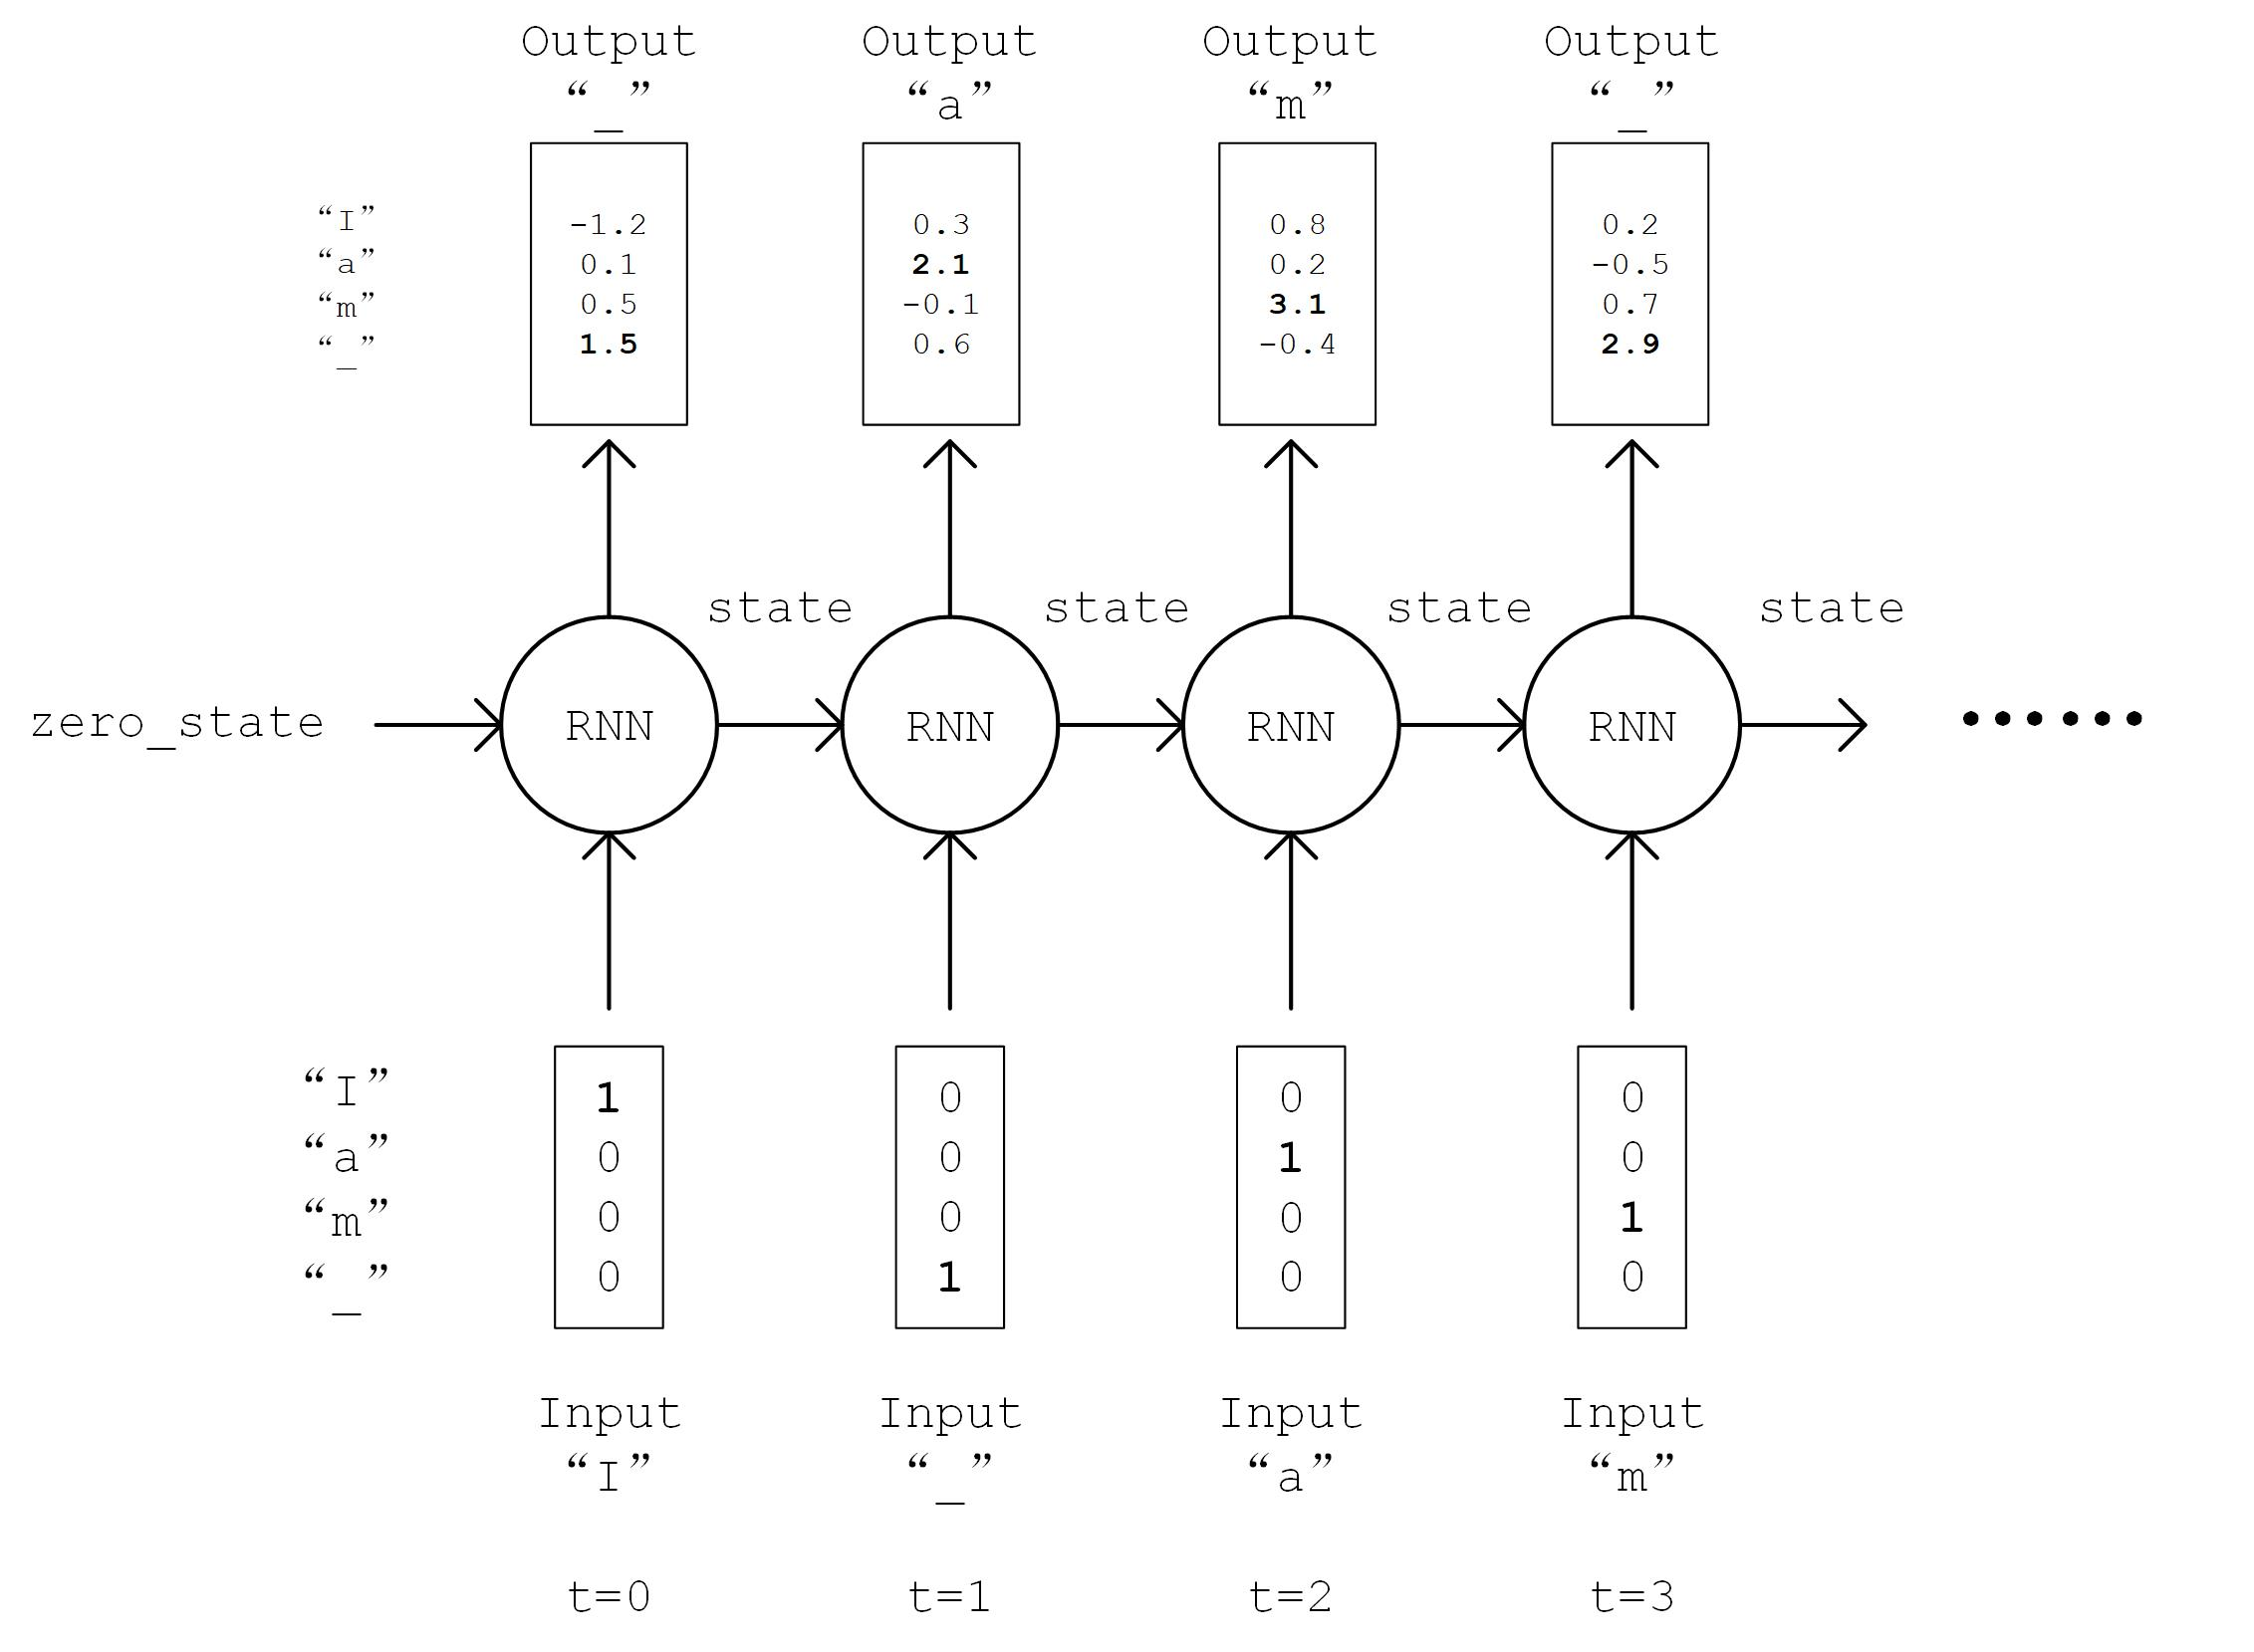


In [87]:
# 我们一个模型，逐个输入一段长为 seq_length 的序列，输出这些序列接续的下一个字符的概率分布。
# 我们从下一个字符的概率分布中采样作为预测值，依次生成下一个字符，完成文本的生成任务。
class DataLoader():
    def __init__(self):
        path = tf.keras.utils.get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
        with open(path, encoding='utf-8') as f:
            self.raw_text = f.read().lower()
        self.chars = sorted(list(set(self.raw_text)))
        # 字符索引化
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        # 文本的字符索引表示
        self.text = [self.char_indices[c] for c in self.raw_text] 

    # 生成一批样本和标签
    def get_batch(self, seq_length, batch_size):
        seq = []
        next_char = []
        for i in range(batch_size):
            index = np.random.randint(0, len(self.text) - seq_length)
            seq.append(self.text[index:index+seq_length]) # 样为一个样本
            next_char.append(self.text[index+seq_length]) # 作为label
        return np.array(seq), np.array(next_char)       # [batch_size, seq_length], [batch_size]

In [115]:
class RNN(tf.keras.Model):
    def __init__(self, num_chars, batch_size, seq_length):
        super().__init__()
        self.num_chars = num_chars
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.cell = tf.keras.layers.LSTMCell(units=256)
        self.dense = tf.keras.layers.Dense(units=self.num_chars)

    def call(self, inputs, from_logits=False):
        inputs = tf.one_hot(inputs, depth=self.num_chars)       # [batch_size, seq_length, num_chars]
        state = self.cell.get_initial_state(batch_size=self.batch_size, dtype=tf.float32)
        for t in range(self.seq_length):
            output, state = self.cell(inputs[:, t, :], state)
            
        logits = self.dense(output)
        if from_logits:
            return logits
        else:
            return tf.nn.softmax(logits)
        
    def predict(self, inputs, temperature=1.):
        batch_size, _ = tf.shape(inputs)
        logits = self(inputs, from_logits=True)
        prob = tf.nn.softmax(logits / temperature).numpy()
        # 按概率从选择字符(的索引). shape=(batch_size, )
        return np.array([np.random.choice(self.num_chars, p=prob[i, :]) 
                         for i in range(batch_size.numpy())])

In [85]:
## Test LSTMCell
# from pprint import pprint

# # [batch_size, seq_length, num_chars]
# inputs = np.array([[0, 1, 2, 1],
#                    [0, 2, 1, 2],
#                    [0, 0, 2, 1],
#                    [1, 2, 1, 0],
#                    [1, 2, 0, 2],
#                    [2, 2, 1, 0]])
# inputs = tf.one_hot(indices=inputs, depth=3)

# outputs = []
# cell = tf.keras.layers.LSTMCell(units=4)
# state = cell.get_initial_state(batch_size=6, dtype=tf.float32)
# for t in range(4):
#     output, state = cell(inputs[:, t, :], state)
#     outputs.append(output)
    

# pprint(outputs)


In [123]:
num_batches = 100
seq_length = 40
batch_size = 50
learning_rate = 1e-3

data_loader = DataLoader()
model = RNN(num_chars=len(data_loader.chars), batch_size=batch_size, seq_length=seq_length)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for batch_index in range(num_batches):
    X, y = data_loader.get_batch(seq_length, batch_size)
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        loss = tf.reduce_mean(loss)
        print("batch %d: loss %f" % (batch_index, loss.numpy()))
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    

batch 0: loss 4.041461
batch 1: loss 4.035250
batch 2: loss 4.011469
batch 3: loss 3.993970
batch 4: loss 3.967393
batch 5: loss 3.919861
batch 6: loss 3.723659
batch 7: loss 3.431792
batch 8: loss 3.272791
batch 9: loss 2.874691
batch 10: loss 3.612118
batch 11: loss 3.223456
batch 12: loss 3.022865
batch 13: loss 3.033648
batch 14: loss 3.169001
batch 15: loss 3.080351
batch 16: loss 3.285697
batch 17: loss 3.070314
batch 18: loss 3.075486
batch 19: loss 3.210213
batch 20: loss 3.236159
batch 21: loss 3.146162
batch 22: loss 3.302474
batch 23: loss 2.938444
batch 24: loss 2.943506
batch 25: loss 3.289488
batch 26: loss 3.106522
batch 27: loss 3.014777
batch 28: loss 3.250325
batch 29: loss 2.876236
batch 30: loss 2.756306
batch 31: loss 3.120358
batch 32: loss 3.209509
batch 33: loss 3.127408
batch 34: loss 3.108924
batch 35: loss 3.117803
batch 36: loss 2.995715
batch 37: loss 3.019139
batch 38: loss 2.937128
batch 39: loss 3.122775
batch 40: loss 3.205913
batch 41: loss 2.784447
ba

In [124]:
X_, _ = data_loader.get_batch(seq_length, 1)
X_.shape
for diversity in [0.2, 0.5, 1.0, 1.2]:
    X = X_
    print("diversity %f:" % diversity)
    for t in range(400):
        y_pred = model.predict(X, diversity)
        print(data_loader.indices_char[y_pred[0]], end='', flush=True)
        X = np.concatenate([X[:, 1:], np.expand_dims(y_pred, axis=1)], axis=-1)
    print("\n")

diversity 0.200000:
 o   eo   a oe t    e      te ee o o o e       oo        e      o   e  o e       a e e io e   soo   eo     e sto  esa i   so   ne o  e   e    e e  ee oor o o      t     o o   n  e o     t a o   e  t  o sa     t s  o  e o t    t     eo   e       ao  e  n   oea ii e   i        oo  s   t       n  eee o    eta   a o  o        i   ao   n          s an     ae    es e     t   s     eso o    oo  ee   a  e

diversity 0.500000:
l s oet    oyidewuea ear eousa en
aoociiaoneh crei l e to  aa ue ppaeoa  eoat  ss at nasisaoas s   iento tec  ils hg raeaee o  eta aaa so o sooe  ise  innrotse  aieao sseo o emoes hoi ams  osoaa dia rait ot es a p soeili tno a t itouosnsoenop ioea ises toaa  io n  y std iao o oieo  
oeoo  es s  nan   eee  etadd acew  sieotdssi ta et da ecole  s  ne niieoin  iriteaa deas  aeiseiooasoitsoere eie ate

diversity 1.000000:
clerdgsrcmks, s iaawol iece ad,fh illu   ds c snacusnnoo nftidruelhsaoeawhsleoao sdre
einhnvipp
ise-llltoudwi r imd
nao; emieweiaateaenv

## Keras Pipeline

### Keras Sequential/Functional API 模式建立模型 

In [ ]:
# 使用Keras Sequential API模式建立模型 
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation=tf.nn.relu),
        tf.keras.layers.Dense(10),
        tf.keras.layers.Softmax()
    ])

In [132]:
# 使用Keras Functional API 模式建立模型 
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dense(units=10)(x)
outputs = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

### 使用 Keras Model 的 compile 、 fit 和 evaluate 方法训练和评估模型

tf.keras.Model.compile 接受 3 个重要的参数：
    * oplimizer ：优化器，可从 tf.keras.optimizers 中选择；
    * loss ：损失函数，可从 tf.keras.losses 中选择；
    * metrics ：评估指标，可从 tf.keras.metrics 中选择。
    
tf.keras.Model.fit 接受 5 个重要的参数：
    * x ：训练数据；
    * y ：目标数据（数据标签）；
    * epochs ：将训练数据迭代多少遍；
    * batch_size ：批次的大小；
    * validation_data ：验证数据，可用于在训练过程中监控模型的性能。

In [133]:
# 当模型建立完成后，通过 tf.keras.Model 的 compile 方法配置训练过程
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

In [137]:
# 使用 tf.keras.Model 的 fit 方法训练模型
model.fit(data_loader.train_data, data_loader.train_label, epochs=num_epochs, batch_size=batch_size)

In [ ]:
# 使用 tf.keras.Model.evaluate 评估训练效果，提供测试数据及标签即可
evaluate_val = model.evaluate(data_loader.test_data, data_loader.test_label)
print(evaluate_val)

## 自定义层、损失函数和评估指标
我们不仅可以继承 tf.keras.Model 编写自己的模型类，也可以继承 tf.keras.layers.Layer 编写自己的层。
(一般来说：一个模型包含一个或多个层)

In [ ]:
# 自定义层--需要继承 tf.keras.layers.Layer 类,并重写 __init__，build 和 call 三个方法
class MyLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        # 初始化代码

    def build(self, input_shape):     # input_shape 是一个 TensorShape 类型对象，提供输入的形状
        # 在第一次使用该层的时候调用该部分代码，在这里创建变量可以使得变量的形状自适应输入的形状，
        # 而不需要使用者额外指定变量形状。
        # 如果已经可以完全确定变量的形状，也可以在__init__部分创建变量
        self.variable_0 = self.add_weight(...)
        self.variable_1 = self.add_weight(...)

    def call(self, inputs):
        # 模型调用的代码（处理输入并返回输出）
        return output
    

In [ ]:
# Test 
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units

    def build(self, input_shape):     # 这里 input_shape 是第一次运行call()时参数inputs的形状
        self.w = self.add_variable(name='w', shape=[input_shape[-1], self.units], 
                                   initializer=tf.zeros_initializer())
        self.b = self.add_variable(name='b', shape=[self.units], 
                                   initializer=tf.zeros_initializer())

    def call(self, inputs):
        y_pred = tf.matmul(inputs, self.w) + self.b
        return y_pred
    
    
class LinearModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer = LinearLayer(units=1)

    def call(self, inputs):
        output = self.layer(inputs)
        return output

## 自定义损失函数和评估指标

In [ ]:
# 自定义损失--需要继承tf.keras.losses.Loss类，重写call方法即可
# 输入:真实值 y_true 和模型预测值 y_pred
# 输出:模型预测值和真实值之间通过自定义的损失函数计算出的损失值。
class MeanSquaredError(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_pred - y_true))

In [ ]:
# 自定义评估指标--需要继承tf.keras.metrics.Metric类,
# 并重写__init__,update_state和result三个方法
class SparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.total = self.add_weight(name='total', dtype=tf.int32, initializer=tf.zeros_initializer())
        self.count = self.add_weight(name='count', dtype=tf.int32, initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        values = tf.cast(tf.equal(y_true, tf.argmax(y_pred, axis=-1, output_type=tf.int32)), tf.int32)
        self.total.assign_add(tf.shape(y_true)[0])
        self.count.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.count / self.total
    
    

array([2, 3])